In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")


In [3]:
#load the data 
df = pd.read_csv(r"c:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\raw\CreditRisk-data.csv")
df.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [4]:
#Convert Transaction Time to Datetime
df["TransactionStartTime"] = pd.to_datetime(
    df["TransactionStartTime"], utc=True
)

df["TransactionStartTime"].dtype


datetime64[ns, UTC]

In [5]:
#Basic Cleaning for RFM
rfm_df = df.copy()

rfm_df = rfm_df.dropna(subset=["CustomerId"])
rfm_df["Value"] = rfm_df["Value"].abs()


In [6]:
#Define Reference Date
snapshot_date = rfm_df["TransactionStartTime"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2019-02-14 10:01:28+0000', tz='UTC')

In [7]:
#Build RFM Metrics
#1️⃣ Recency
#Days since last transaction
#2️⃣ Frequency
#Number of transactions
#3️⃣ Monetary
#Total value spent
rfm = (
    rfm_df
    .groupby("CustomerId")
    .agg({
        "TransactionStartTime": lambda x: (snapshot_date - x.max()).days,
        "TransactionId": "count",
        "Value": "sum"
    })
    .reset_index()
)

rfm.columns = ["CustomerId", "Recency", "Frequency", "Monetary"]
rfm.head()
rfm.to_csv(r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process\RFM_metrics.csv", index=False)

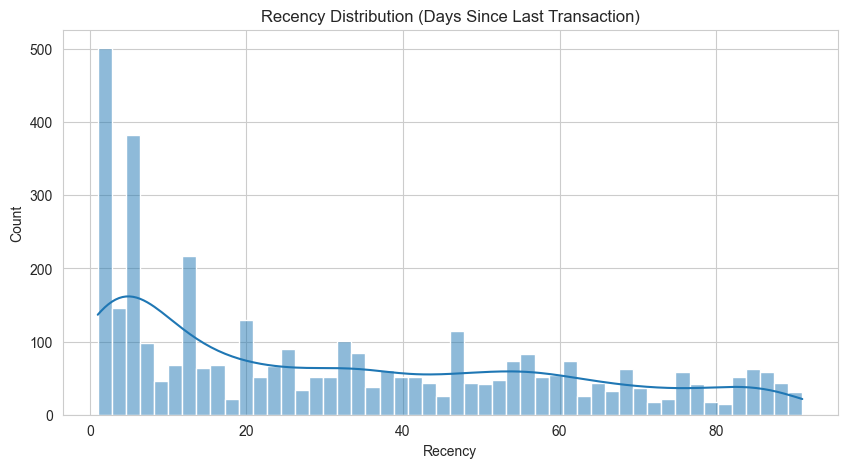

In [8]:
#Distribution Analysis
#Recency Distribution
sns.histplot(rfm["Recency"], bins=50, kde=True)
plt.title("Recency Distribution (Days Since Last Transaction)")
plt.show()


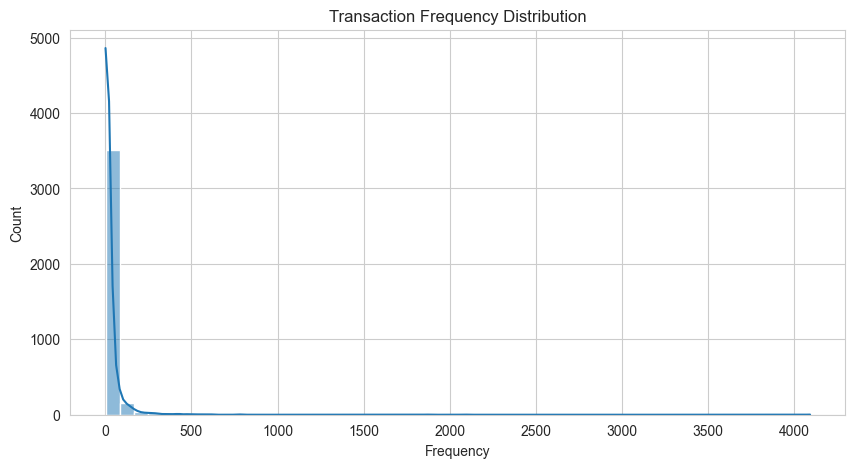

In [9]:
#Frequency Distribution
sns.histplot(rfm["Frequency"], bins=50, kde=True)
plt.title("Transaction Frequency Distribution")
plt.show()


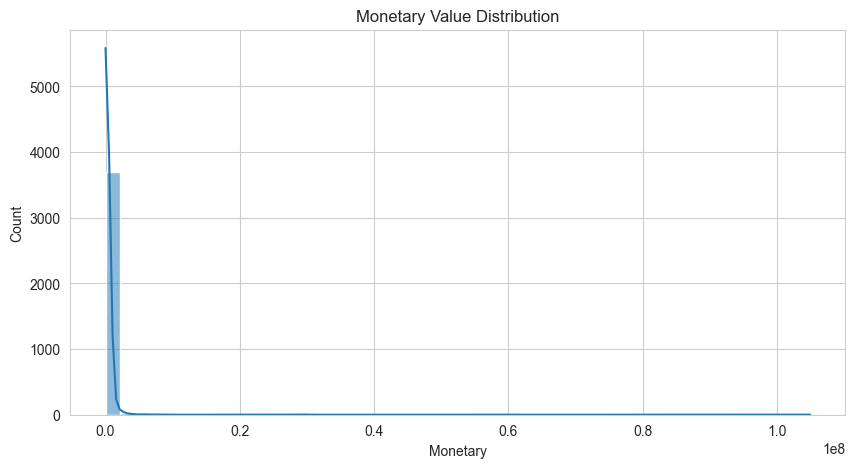

In [10]:
#Monetary Distribution
sns.histplot(rfm["Monetary"], bins=50, kde=True)
plt.title("Monetary Value Distribution")
plt.show()


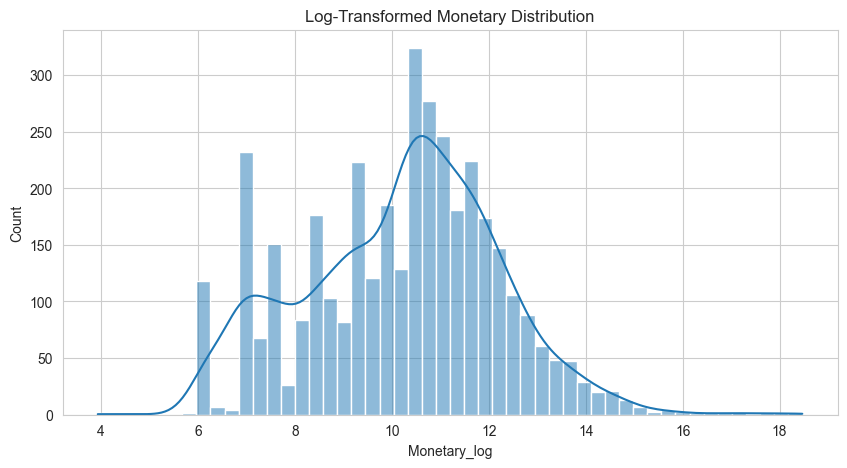

In [11]:
#Log Transform Monetary
rfm["Monetary_log"] = np.log1p(rfm["Monetary"])

sns.histplot(rfm["Monetary_log"], bins=50, kde=True)
plt.title("Log-Transformed Monetary Distribution")
plt.show()


In [12]:
#Build RFM Scores (Quantile-Based)
#We score customers from 1 (worst) → 5 (best)
rfm["R_score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1])
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5])

rfm[["R_score", "F_score", "M_score"]] = rfm[["R_score","F_score","M_score"]].astype(int)


In [14]:
#Composite RFM Score
rfm["RFM_score"] = (
    rfm["R_score"] +
    rfm["F_score"] +
    rfm["M_score"]
)
rfm.head()

,CustomerId,Recency,Frequency,Monetary,Monetary_log,R_score,F_score,M_score,RFM_score
0,CustomerId_1,84,1,10000,9.210440,1,1,2,4
1,CustomerId_10,84,1,10000,9.210440,1,1,2,4
2,CustomerId_1001,90,5,30400,10.322231,1,2,3,6
3,CustomerId_1002,26,11,4775,8.471359,3,4,2,9
4,CustomerId_1003,12,6,32000,10.373522,4,3,3,10


In [17]:
#Define Credit Risk Proxy (Target Variable)
rfm["Risk_Label"] = np.where(rfm["RFM_score"] <= 6, 1, 0)
#1 = High Risk (Bad)
# 0 = Low Risk (Good)
rfm.head()



,CustomerId,Recency,Frequency,Monetary,Monetary_log,R_score,F_score,M_score,RFM_score,Risk_Label
0,CustomerId_1,84,1,10000,9.210440,1,1,2,4,1
1,CustomerId_10,84,1,10000,9.210440,1,1,2,4,1
2,CustomerId_1001,90,5,30400,10.322231,1,2,3,6,1
3,CustomerId_1002,26,11,4775,8.471359,3,4,2,9,0
4,CustomerId_1003,12,6,32000,10.373522,4,3,3,10,0


In [21]:
rfm.to_csv(r"C:\Users\hp\Pictures\Bati Bank\Credit-Risk-Probability-Model-for-Alternative-Data\data\process/rfm_features.csv", index=False)


In [ ]:
#Correlation Analysis (RFM)
corr = rfm[["Recency", "Frequency", "Monetary"]].corr()
corr


,Recency,Frequency,Monetary
Recency,1.000000,-0.153912,-0.035168
Frequency,-0.153912,1.000000,0.504162
Monetary,-0.035168,0.504162,1.000000


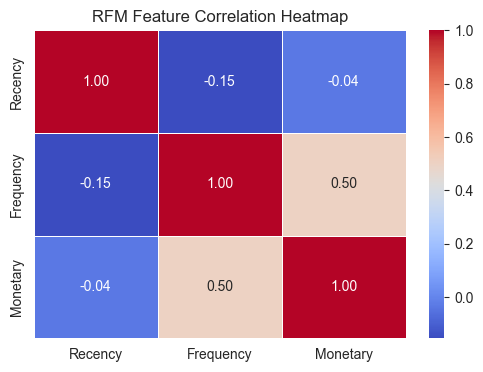

In [23]:
#RFM Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("RFM Feature Correlation Heatmap")
plt.show()


# RFM Analysis Results

## Overview

The RFM (Recency, Frequency, Monetary) analysis provides insights into customer behavior based on transactional data. The analysis is represented in the table below, detailing individual customer scores across three dimensions:

| CustomerId   | Recency | Frequency | Monetary | Monetary_log | R_score | F_score | M_score | RFM_score |
|--------------|---------|-----------|----------|--------------|---------|---------|---------|-----------|
| CustomerId_1 | 84      | 1         | 10000    | 9.210440     | 1       | 1       | 2       | 4         |
| CustomerId_10| 84      | 1         | 10000    | 9.210440     | 1       | 1       | 2       | 4         |
| CustomerId_1001| 90    | 5         | 30400    | 10.322231    | 1       | 2       | 3       | 6         |
| CustomerId_1002| 26    | 11        | 4775     | 8.471359     | 3       | 4       | 2       | 9         |
| CustomerId_1003| 12    | 6        | 32000    | 10.373522    | 4       | 3       | 3       | 10        |

The key attributes are:
- **Recency**: Days since the last purchase.
- **Frequency**: Number of transactions in a defined period.
- **Monetary**: Total spending by the customer.

## Distribution Analysis

### Log-Transformed Monetary Distribution

![Log-Transformed Monetary Distribution](path_to_log_transformed_distribution_image)

- The histogram above shows the log-transformed monetary values, which help normalize the skewness in the data. A clearer distribution trend assists in understanding customer spending.

### Monetary Value Distribution

![Monetary Value Distribution](path_to_monetary_distribution_image)

- This plot illustrates that while most monetary values cluster around the lower amounts, a few high-value transactions significantly influence the average.

### Transaction Frequency Distribution

![Transaction Frequency Distribution](path_to_frequency_distribution_image)

- The frequency histogram reveals that a significant proportion of customers have low transaction counts. A few customers, however, exhibit high transaction frequencies.

### Recency Distribution

![Recency Distribution](path_to_recency_distribution_image)

- The distribution of recency values indicates that many customers have made purchases recently, which tapers off as recency increases. This pattern can guide targeted marketing efforts.

## Insights and Recommendations

- **High-Value Customers**: Customers like CustomerId_1003 demonstrate high RFM scores and should be prioritized for loyalty programs.
- **Engagement Opportunities**: Customers with high recency but low frequency (like CustomerId_1002) may need re-engagement strategies.
- **Revenue Contributions**: A small percentage of customers drive most transactions, suggesting a focus on retaining these high-value clients.

### Correlation Heatmap

![RFM Feature Correlation Heatmap](path_to_heatmap_image)

- The heatmap provides an insightful overview of the relationships among recency, frequency, and monetary values. Negative correlations between recency and frequency suggest that customers who purchase frequently tend to have more recent transactions.

## Conclusion

This RFM analysis provides actionable insights into customer behavior, allowing businesses to tailor marketing strategies effectively. By understanding customer values and engagement levels, organizations can improve retention and boost overall profitability.

In [ ]:
#Test of RFM Feature Engineering
from src.data_processing import build_rfm

def test_build_rfm_features():
    df = pd.DataFrame({
        "CustomerId": [1, 1, 2],
        "TransactionStartTime": pd.to_datetime(
            ["2024-01-01", "2024-01-05", "2024-01-03"], utc=True
        ),
        "Amount": [100, 200, 300]
    })

    rfm = build_rfm(
        df,
        customer_col="CustomerId",
        date_col="TransactionStartTime",
        amount_col="Amount"
    )

    assert set(rfm.columns) == {"CustomerId", "Recency", "Frequency", "Monetary"}
    assert rfm.loc[rfm.CustomerId == 1, "Frequency"].iloc[0] == 2
